# 共轭梯度法 Conjugate Gradient Method

### 1. CG 简单实现

解线性方程组 $Ax=b$，其中 $A$ 为正定矩阵。

对于$A\in \R^{n\times n}$，利用CG只需要$n$步即可完成方程组的精确解（解析解）。【试理解证明过程】

CG：通过矩阵乘法完成矩阵的逆的运算。

在一次循环中只需要完成一次矩阵乘法，CG算法的最差时间复杂度为$O(n^3)$ 

（Recall一般线性方程组的高斯消元时间复杂度也为$O(n^3)$）

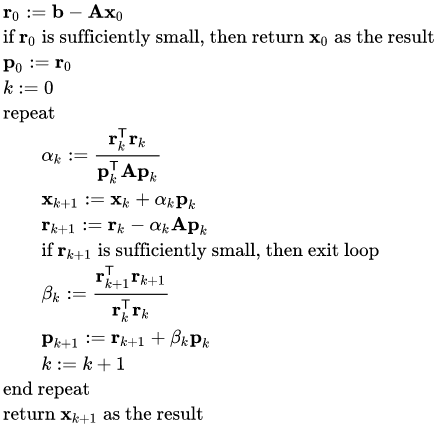

In [1]:
import numpy as np
np.set_printoptions(linewidth=100)

# https://en.wikipedia.org/wiki/Conjugate_gradient_method
# A [m x m], b [m], x0 [m]
def cg(A, b, x0, eps=1e-3, print_progress=False):
    m = b.shape[0]
    # 初始解（注意此处应该复制x0，否则程序退出时会修改x0）
    x = np.copy(x0)
    # 初始残差向量
    r = b - np.dot(A, x)
    # 初始共轭梯度
    p = r

    for k in range(m):
        # 矩阵乘法
        Ap = np.dot(A, p)
        rr = r.dot(r)
        alpha = rr / p.dot(Ap)
        # 更新解
        x += alpha * p
        # 计算新残差向量
        rnew = r - alpha * Ap
        # 测试是否收敛
        norm = np.linalg.norm(rnew)
        if print_progress:
            print(f"Iter {k}, residual norm = {norm}")
        if norm < eps:
            break
        beta = rnew.dot(rnew) / rr
        # 更新共轭梯度
        p = rnew + beta * p
        # 更新残差向量
        r = rnew

    return x

进行简单的测试：

In [2]:
np.random.seed(123)
m = 10
x = np.random.normal(size=(m, m))
# A 为正定矩阵
A = x.transpose().dot(x)
b = np.random.normal(size=m)
# 直接求解
sol = np.linalg.solve(A, b)
sol

array([-136.71894832,  -33.85176812,   41.84149034,   73.42723076,   12.50311233,  -41.91028953,
         -6.01395804,  -30.7294723 ,  -24.21718752,  -68.80957079])

CG 求解：

In [3]:
cg(A, b, x0=np.zeros(shape=m), print_progress=True)

Iter 0, residual norm = 3.4114500760207527
Iter 1, residual norm = 5.7628912322110075
Iter 2, residual norm = 7.818450458630155
Iter 3, residual norm = 7.264409878364026
Iter 4, residual norm = 10.31938154121869
Iter 5, residual norm = 8.114715301977203
Iter 6, residual norm = 4.32693288275113
Iter 7, residual norm = 6.7263924705432485
Iter 8, residual norm = 9.42968257137525
Iter 9, residual norm = 3.2790662538160885e-07


array([-136.71894832,  -33.85176812,   41.84149034,   73.42723076,   12.50311233,  -41.91028953,
         -6.01395804,  -30.7294723 ,  -24.21718751,  -68.80957079])

数学上可以证明，CG 可以保证在 $m$ 步后收敛，其中 $m$ 是 $A$ 的维度，但要注意前提 $A$ 正定。

- 正定：
  - $A$ 所有的特征值>0
  - 正定必对称
  - 正定def：$\forall x_{n\times 1}\neq0, x^TAx >0 $ (≥为非负定)


实际使用中如果 $A$ 的**性质较好（条件数（最大特征值与最小特征值的比值）较小）**，CG 往往在远小于 $m$ 步时就可以收敛。

In [ ]:
np.random.seed(123)
m = 1000
x = np.random.normal(size=(m, m))
# A 为正定矩阵
A = x.transpose().dot(x) / m
# 计算条件数，即最大特征值与最小特征值的比值
print(np.linalg.cond(A))
b = np.random.normal(size=m)
# 难以收敛
# cg(A, b, x0=np.zeros(shape=m), print_progress=True)
print()
A = A + np.eye(m)
print(np.linalg.cond(A))
sol = cg(A, b, x0=np.zeros(shape=m), print_progress=True)

### 2. 更通用的 CG 实现

适用于CG的一些矩阵【重点是验证正定性】：
- 非退化分布的协方差矩阵（具有多重共线性等）
- $X^TX+\lambda I$

CG on $X^TX+\lambda I$:

*ABSTRACTION!*
```python
def Afn(v ,X, lambda):
    Av = X_T*X*v+lambda*I*v
```
时间复杂度为$O(np)$
若正常Gauss法则为$O(p^2)$

在上述实现中我们可以发现，用到 $A$ 的地方仅仅是计算矩阵乘法 $Ax$，而并未直接使用其他信息，例如 $A$ 中每个元素的取值。因此，我们可以传入一个计算矩阵乘法的函数给 CG，使其可以适用于不同类型的矩阵。

In [ ]:
def cg(Afn, b, x0, eps=1e-3, print_progress=False, **Afn_args):
    m = b.shape[0]
    # 初始解（注意此处应该复制x0，否则程序退出时会修改x0）
    x = np.copy(x0)
    # 初始残差向量
    r = b - Afn(x, **Afn_args)
    # 初始共轭梯度
    p = r

    for k in range(m):
        # 矩阵乘法
        Ap = Afn(p, **Afn_args)
        rr = r.dot(r)
        alpha = rr / p.dot(Ap)
        # 更新解
        x += alpha * p
        # 计算新残差向量
        rnew = r - alpha * Ap
        # 测试是否收敛
        norm = np.linalg.norm(rnew)
        if print_progress:
            print(f"Iter {k}, residual norm = {norm}")
        if norm < eps:
            break
        beta = rnew.dot(rnew) / rr
        # 更新共轭梯度
        p = rnew + beta * p
        # 更新残差向量
        r = rnew

    return x

此时要使用 CG 时我们需要提供一个函数，而不是 $A$ 本身：

In [ ]:
def mat_prod(x, mat):
    return mat.dot(x)

sol = cg(mat_prod, b, x0=np.zeros(shape=m), print_progress=True, mat=A)

这种通用写法的好处是我们可以针对一些特殊的矩阵定义高效的矩阵运算。以对角矩阵为例：

In [ ]:
def diag_mat_prod(x, diag_elements):
    return diag_elements * x  # 逐元素相乘，非矩阵乘法

sol = cg(diag_mat_prod, b, x0=np.zeros(shape=m), print_progress=True, diag_elements=np.diagonal(A))